In [99]:
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
from matplotlib import rcParams
import igraph as ig
from community import community_louvain as louvaine
import bbox
import pandas as pd
from IPython.display import SVG, display, Image
def show_svg(file):
    display(SVG(filename=file))

# Formato para matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['axes.labelsize'] = 40
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

In [100]:
dolphins = nx.read_gml('datasets/dolphins.gml')
genders = pd.read_csv("datasets/dolphinsGender.txt",
                          delimiter = "\t", header = None, names = ["ID", "Gender"])
genders.set_index("ID", inplace = True)
genders = pd.Series(genders["Gender"])

# Agregamos el atributo de sexo a cada nodo
for i in dolphins.nodes:
    dolphins.nodes[i]["Gender"] = genders[i]
# Por lo que ahora podemos acceder al genero de cada delfin como dolphins.nodes[ID]["Gender"]

In [101]:
dolphins_ig = ig.Graph.from_networkx(dolphins)
com_im = dolphins_ig.community_infomap()
com_lv = louvaine.best_partition(dolphins)
com_bt = dolphins_ig.community_edge_betweenness(clusters = None, directed = False, weights = None)
com_fg = dolphins_ig.community_fastgreedy(weights = None)

pos = nx.layout.fruchterman_reingold_layout(dolphins)

In [102]:
def cluster_to_dict(clusters, G) -> dict:
    """
    Arma un diccionario con los nombres de los nodos
    como keys y el id del cluster como valor.
    """
    dic = {}
    for i, cluster in enumerate(sorted(list(clusters), key = len, reverse = True)):
        for node in cluster:
            dic[G.vs[node]['_nx_name']] = i
    return dic

In [103]:
### Formato custom de ploteo de grafos.
CUSTOM_FORMAT = {"node_size": 100, "edgecolors": "black",
                "linewidths": 1}

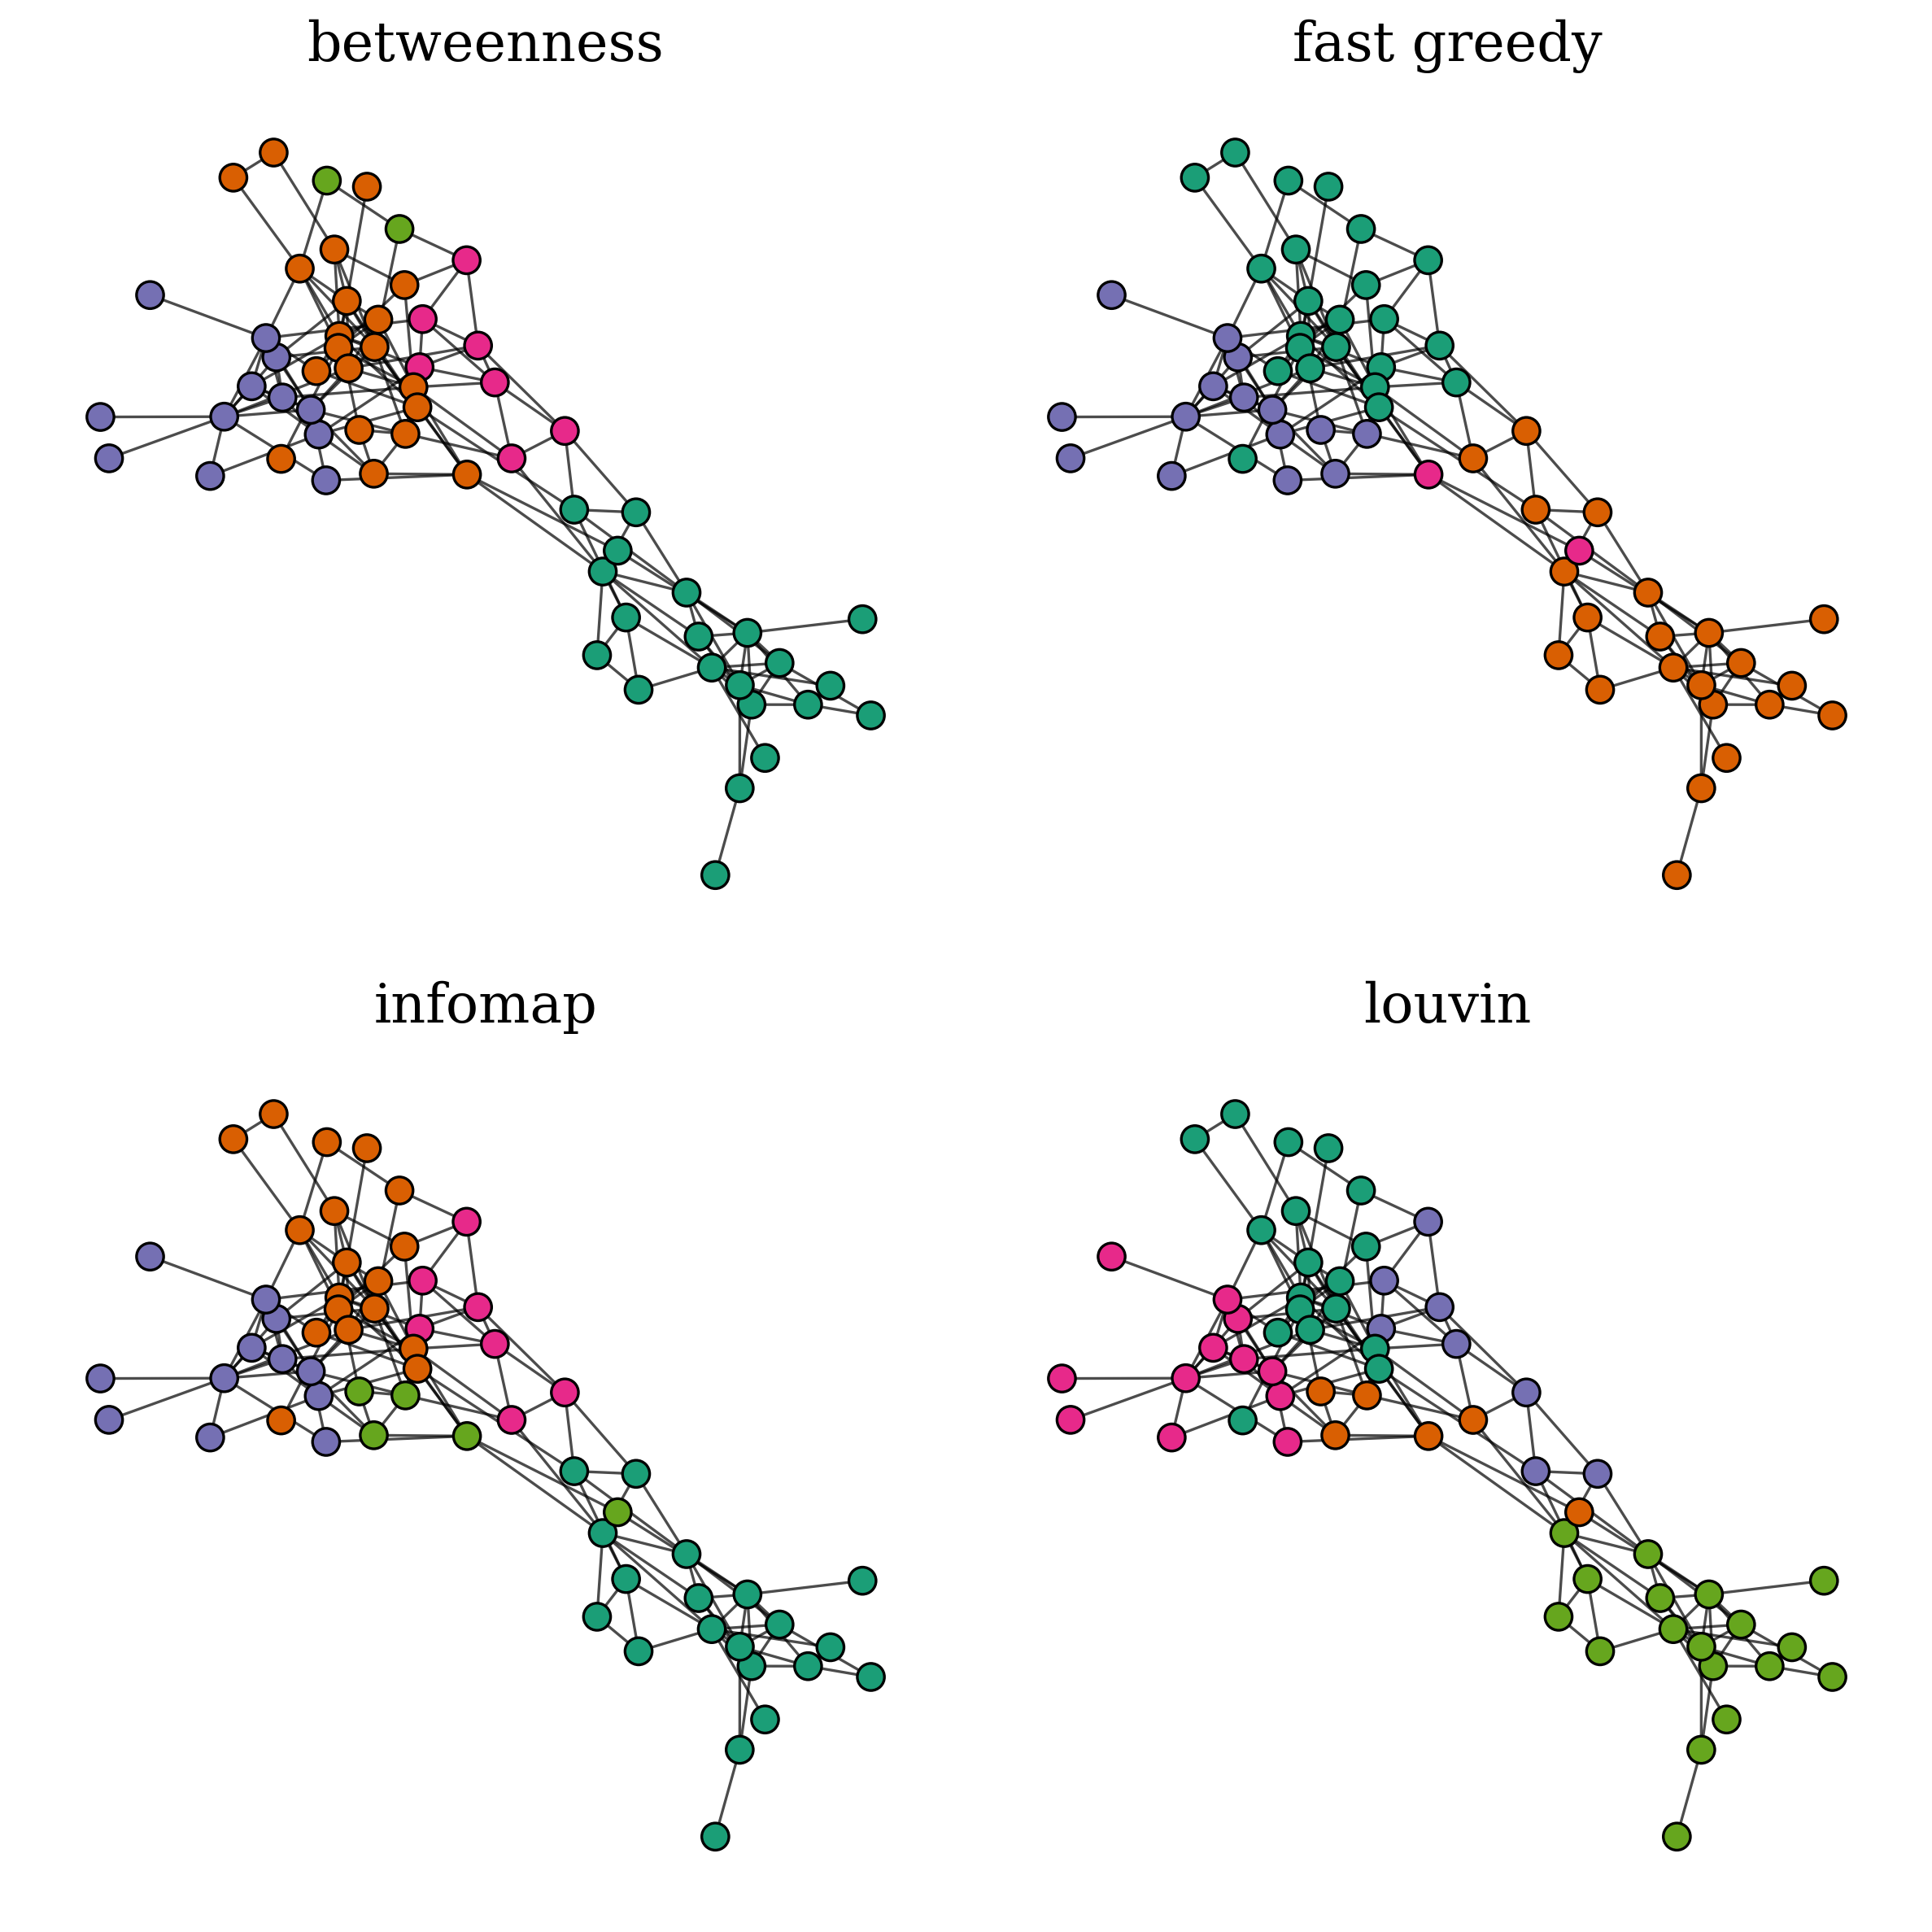

In [104]:
dic_com_bt = cluster_to_dict(com_bt.as_clustering(), dolphins_ig)
dic_com_fg = cluster_to_dict(com_fg.as_clustering(), dolphins_ig)
dic_com_im = cluster_to_dict(com_im, dolphins_ig)
particiones = {"betweenness": dic_com_bt, "fast greedy": dic_com_fg, 
               "infomap": dic_com_im, "louvin": com_lv
               }
fig, axs = plt.subplots(2, 2, figsize = (10, 10), tight_layout=True)

for i, ax in enumerate(fig.axes):
    nx.draw_networkx_nodes(dolphins,
                           pos = pos,
                           node_color = [plt.get_cmap('Dark2')(list(particiones.values())[i][v]) for v in dolphins.nodes()],
                           ax = ax,
                           **CUSTOM_FORMAT)
    nx.draw_networkx_edges(dolphins,
                           pos = pos,
                           ax = ax,
                           alpha = .7)
    ax.set_title(f"{list(particiones.keys())[i]}", fontsize=20)
    ax.axis('off')

plt.show()


In [105]:
def silhouette(Red, particion, ax): 
  S=[]
  limites=[0]

  for cluster in set(particion.values()): 
    nodos_en_cluster = [nodo for (nodo, value) in particion.items() if value == cluster] 
    S_cluster=[]

    for nodo in nodos_en_cluster:
      distancias_dentro=[]
      distancias_fuera=[]

      for nodo_en_cluster in nodos_en_cluster:
        if nodo != nodo_en_cluster:
          distancias_dentro.append(nx.shortest_path_length(Red, source=nodo, target=nodo_en_cluster, weight=None))

      for nodo_fuera in Red.nodes():
        if particion[nodo_fuera] != cluster:
          distancias_fuera.append(nx.shortest_path_length(Red, source=nodo, target=nodo_fuera, weight=None)) 
      
      distancia_media_dentro = np.mean(distancias_dentro)
      distancia_mean_fuera = np.mean(distancias_fuera)
      S_cluster.append((distancia_mean_fuera - distancia_media_dentro)/np.max([distancia_mean_fuera,distancia_media_dentro]))

    S_cluster=sorted(S_cluster)
    limites.append(len(S_cluster)+limites[-1])
    S = S + S_cluster

  S_media = np.mean(S)
  
  for i in range(len(limites)-1):
    ax.barh(range(limites[i],limites[i+1]), S[limites[i]:limites[i+1]])
  ax.axvline(S_media, ls="--", color="black")
  return S, S_media

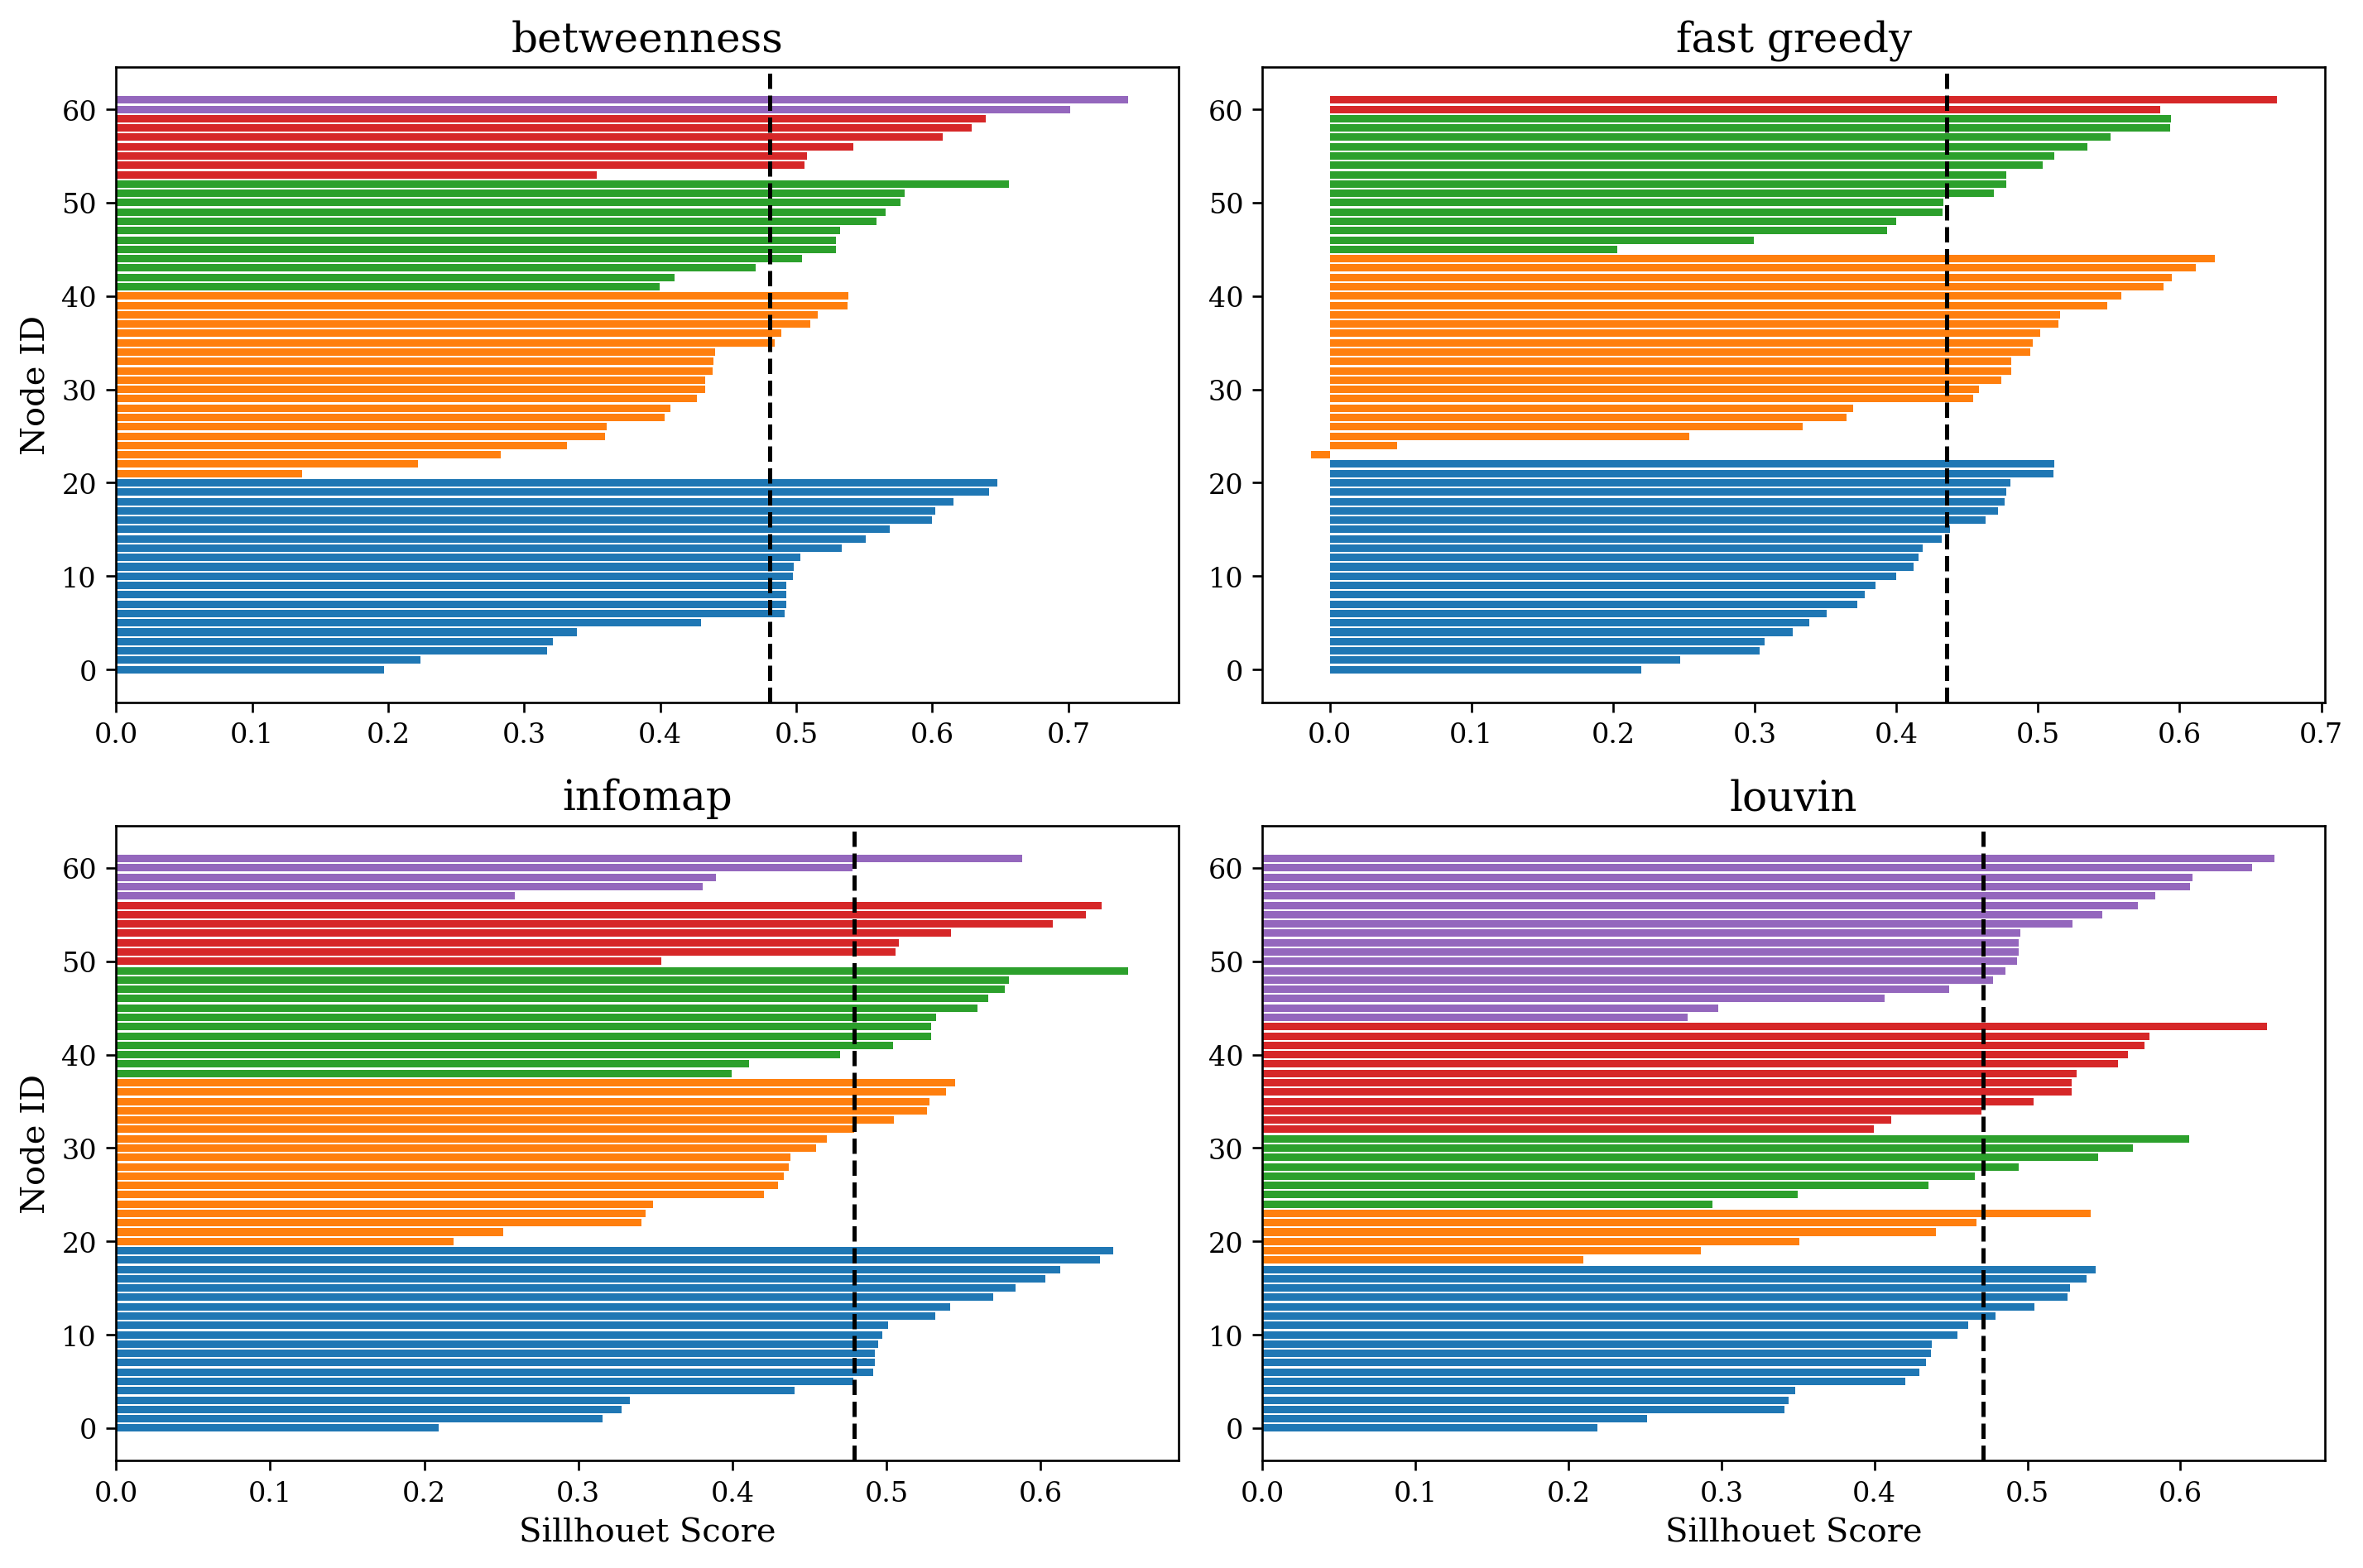

In [108]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
axs = axs.flatten()

for i, (methodname, particion) in enumerate(particiones.items()):
    s, s_media = silhouette(dolphins, particion, axs[i])
    axs[i].set_title(methodname, fontsize=15)

axs[2].set_xlabel("Sillhouet Score", fontsize=12)
axs[3].set_xlabel("Sillhouet Score", fontsize=12)
axs[0].set_ylabel("Node ID", fontsize=12)
axs[2].set_ylabel("Node ID", fontsize=12)

plt.show()